### Project Setup

In [1787]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [1788]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [1789]:
# Eliminam din dataset NaN si +- Inifity
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [1790]:
# Inlocuiesc NaN si +- Infinity cu mediana pe coloane pentru
#df = df.replace([np.inf, -np.inf], np.nan)
#df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

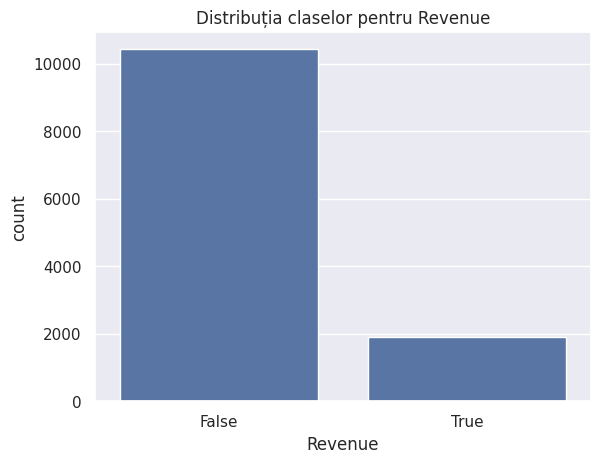

In [1791]:
# Verificarea echilibrului claselor
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

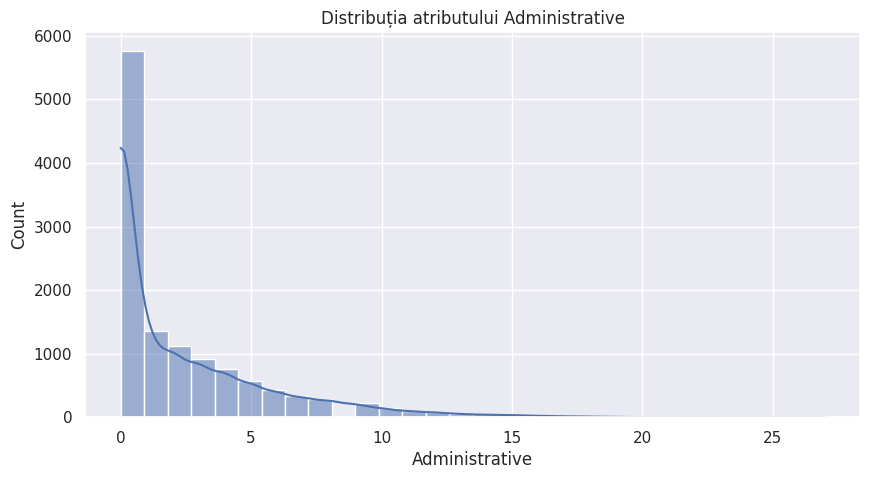

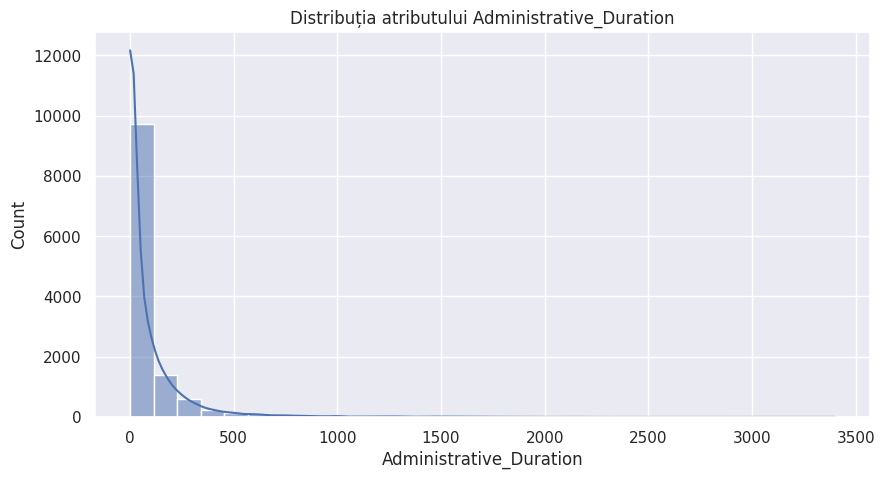

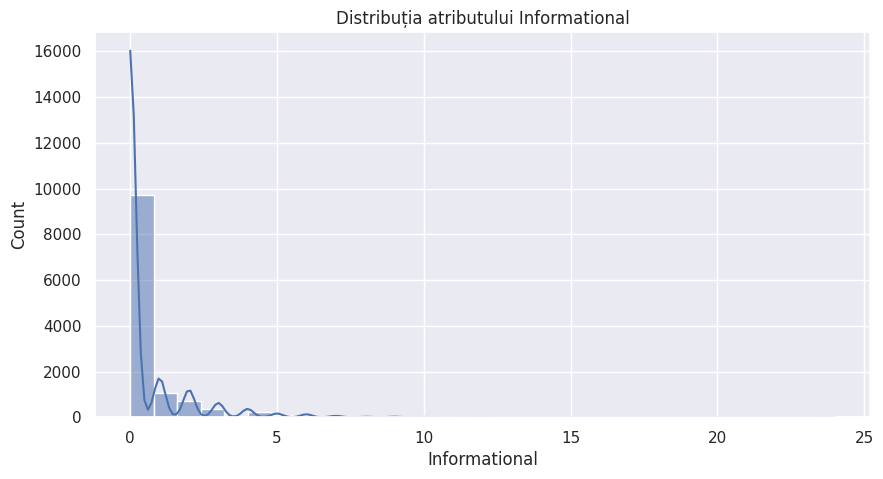

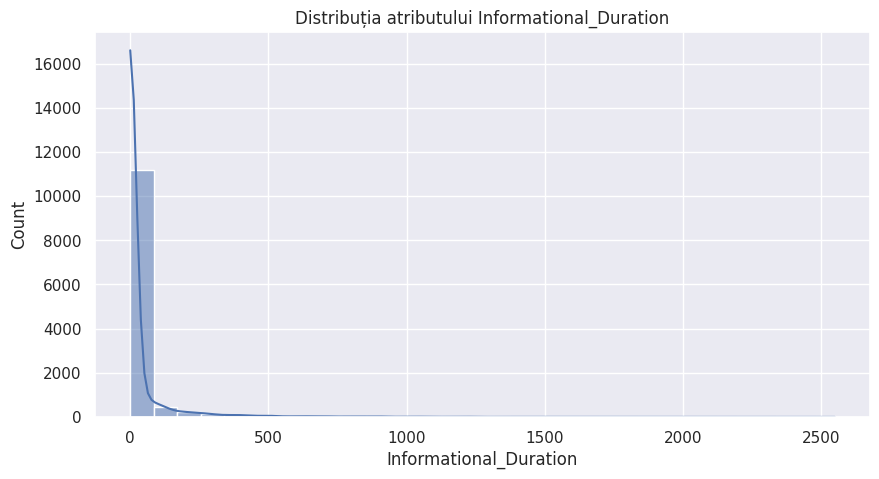

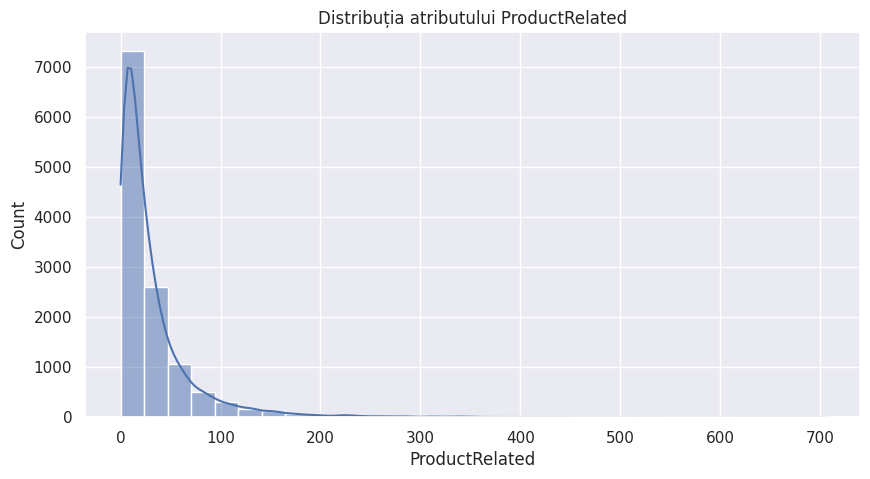

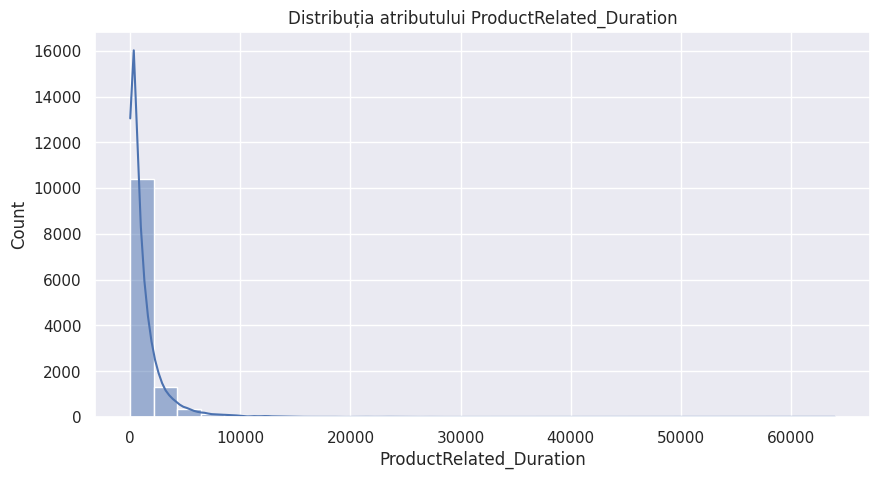

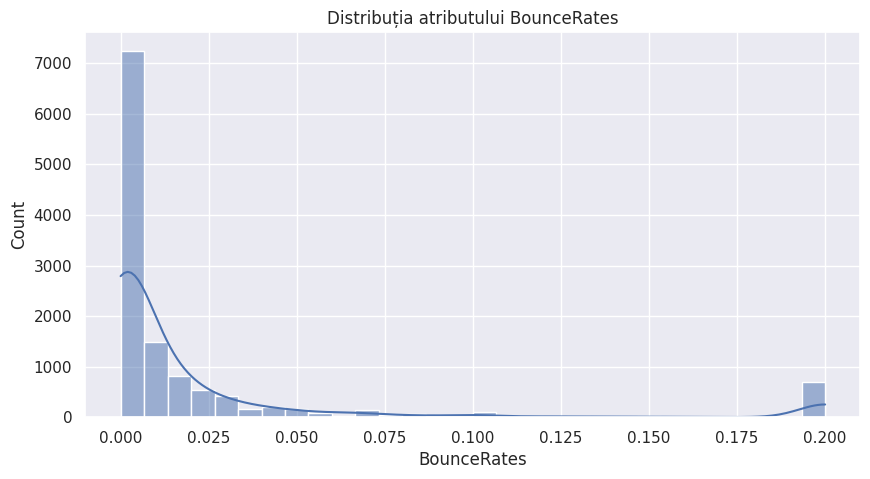

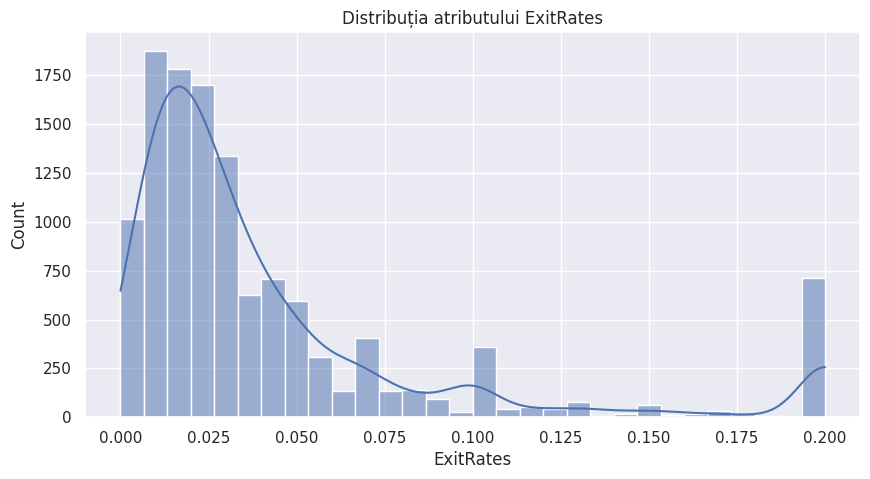

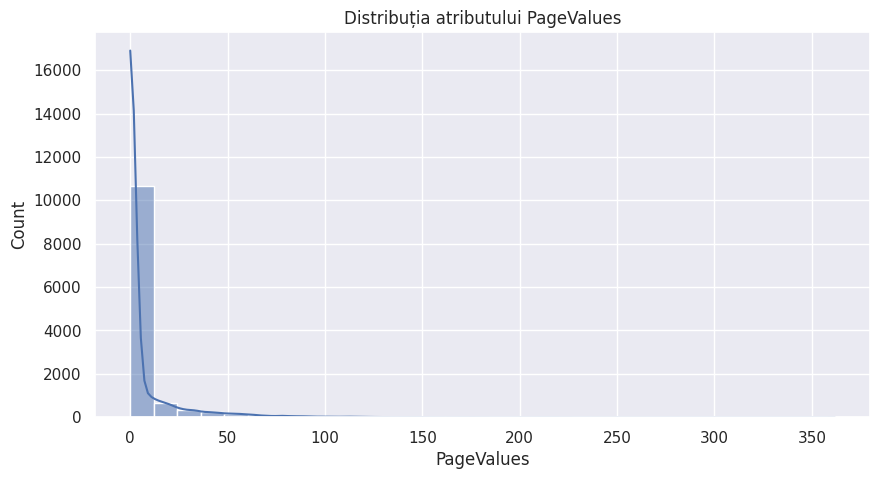

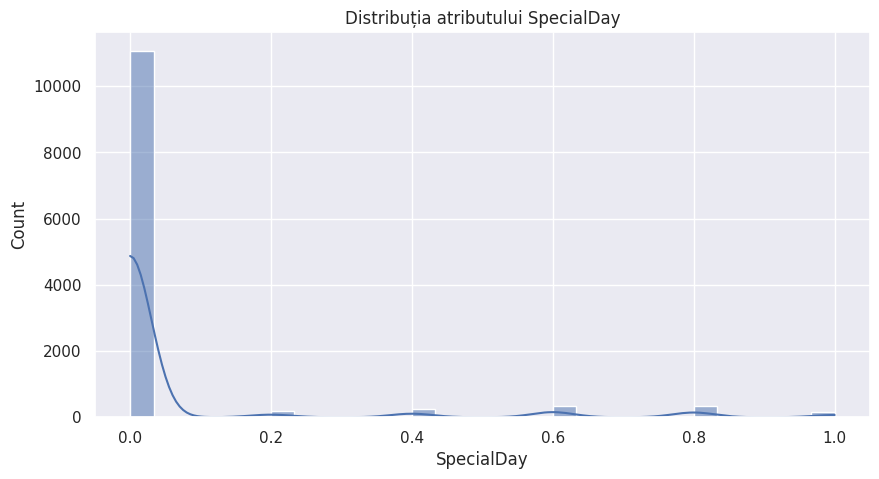

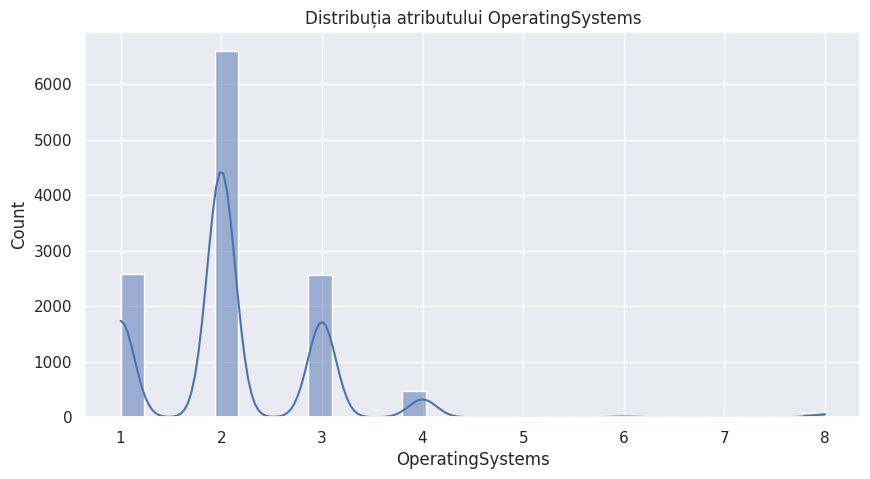

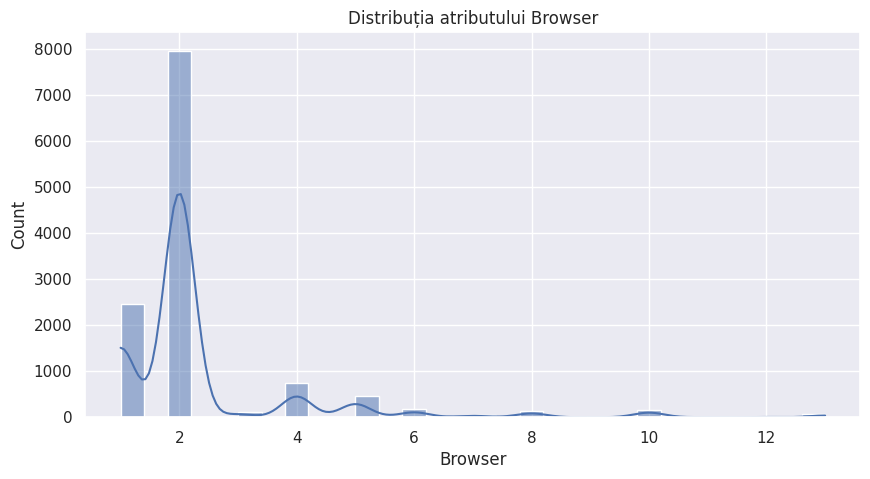

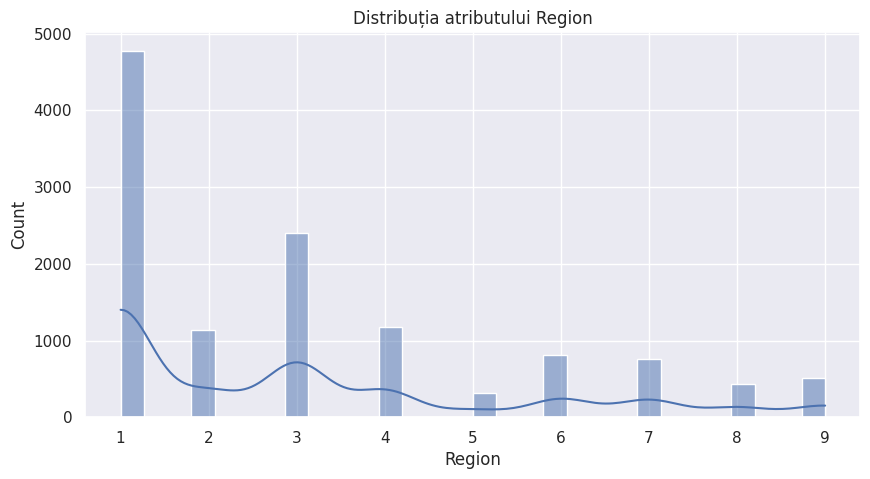

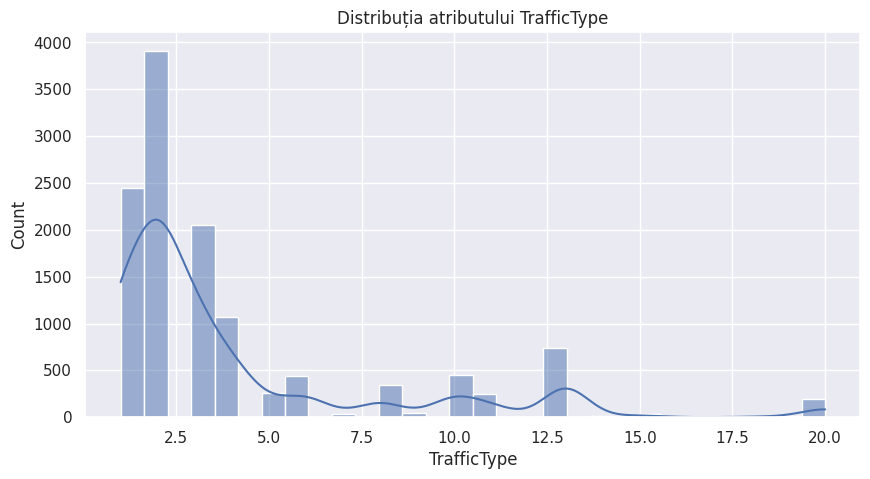

In [1792]:
# Identificarea atributelor numerice
numeric_attributes = df.select_dtypes(include=np.number).columns.tolist()

# Vizualizare distribuție pentru atribute numerice
for attribute in numeric_attributes:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[attribute], bins=30, kde=True)
    plt.title(f'Distribuția atributului {attribute}')
    plt.show()

### 2.A Atribute Categorice

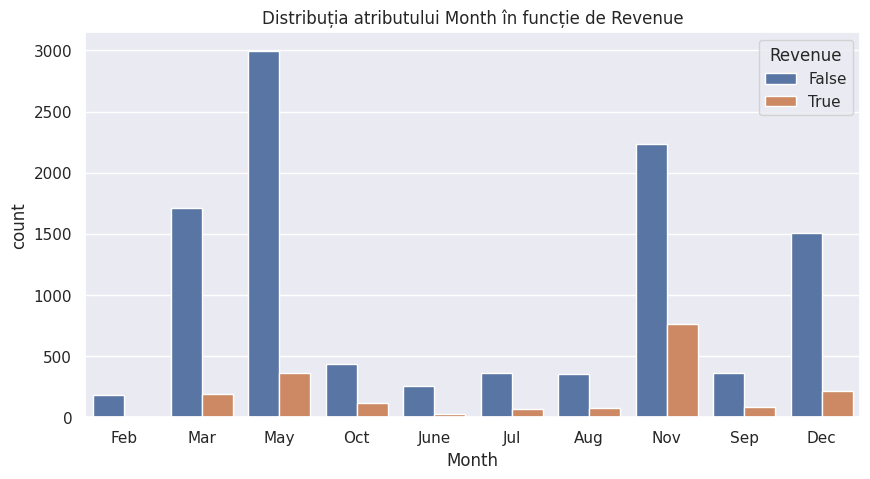

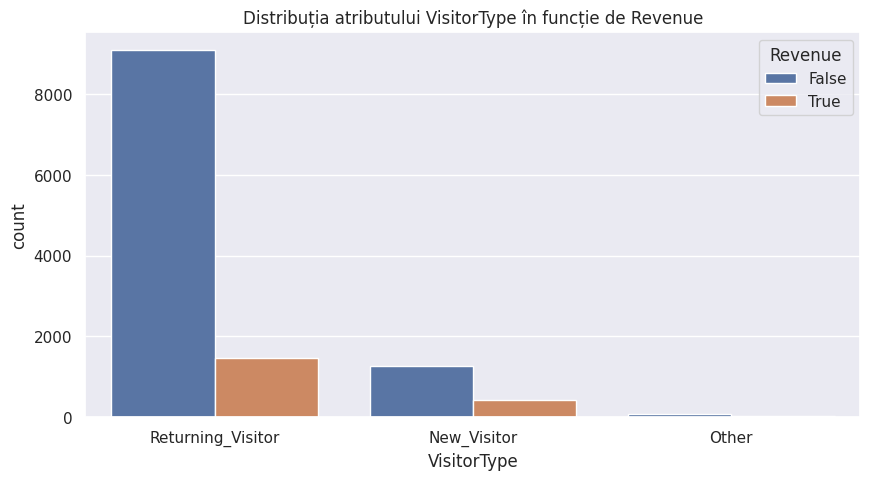

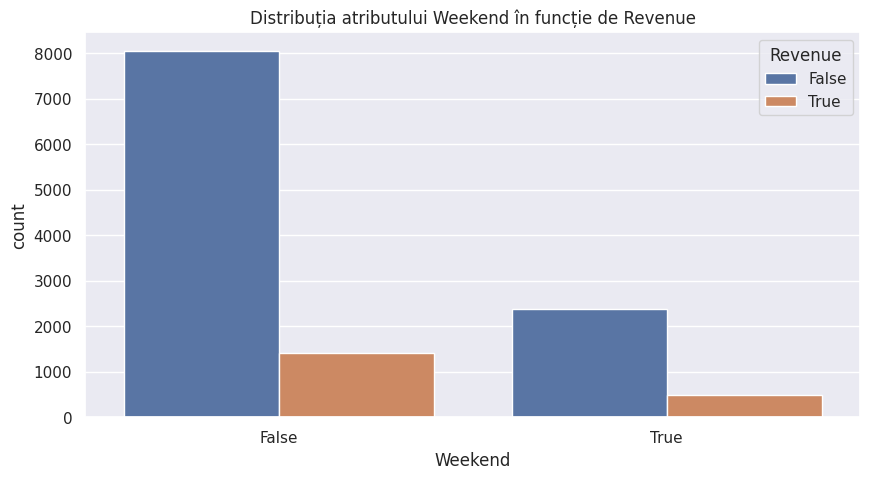

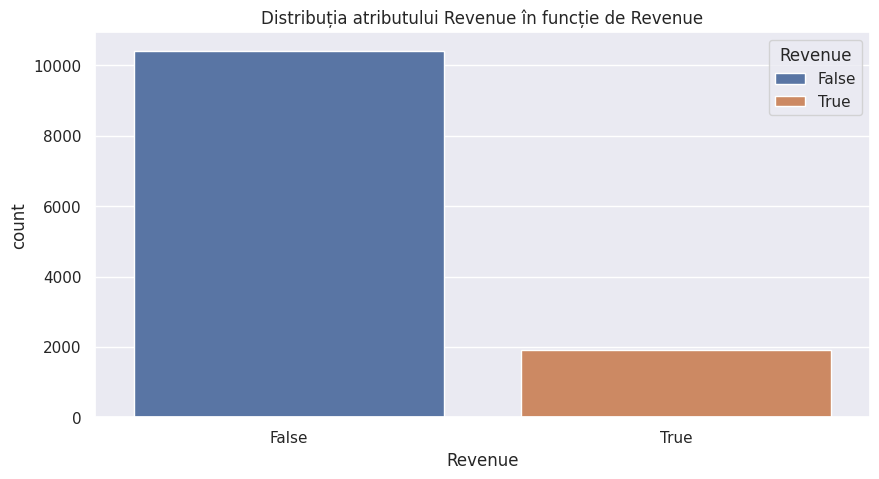

In [1793]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

# Vizualizare distribuție pentru atribute categorice
for attribute in categorical_attributes:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=attribute, data=df, hue='Revenue')
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




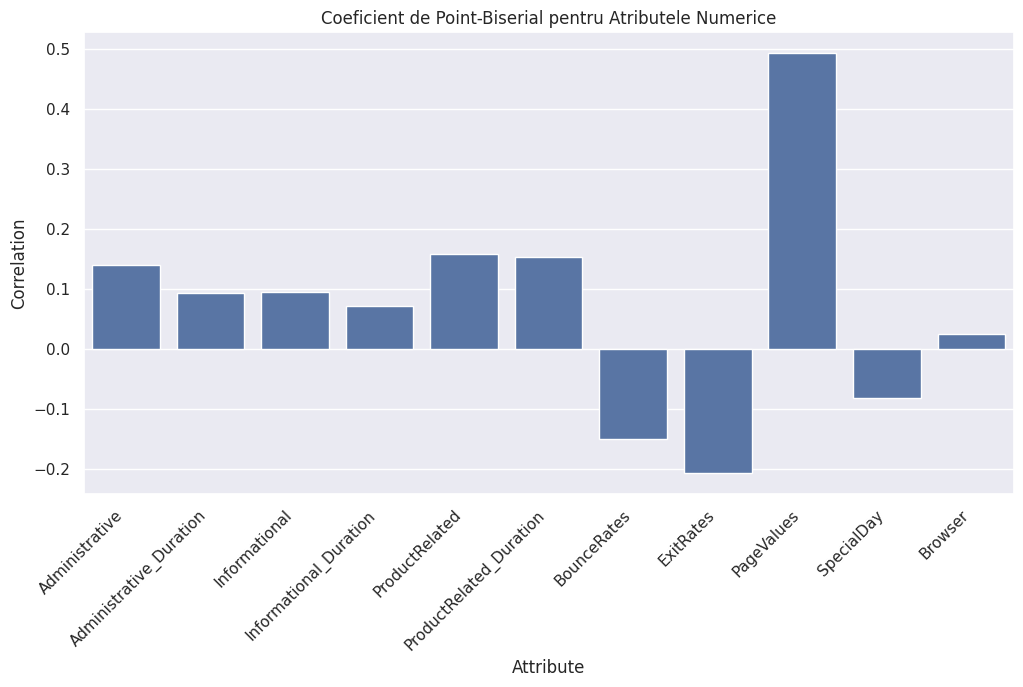

In [1794]:
correlation_results_numeric = []

for attribute in numeric_attributes:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




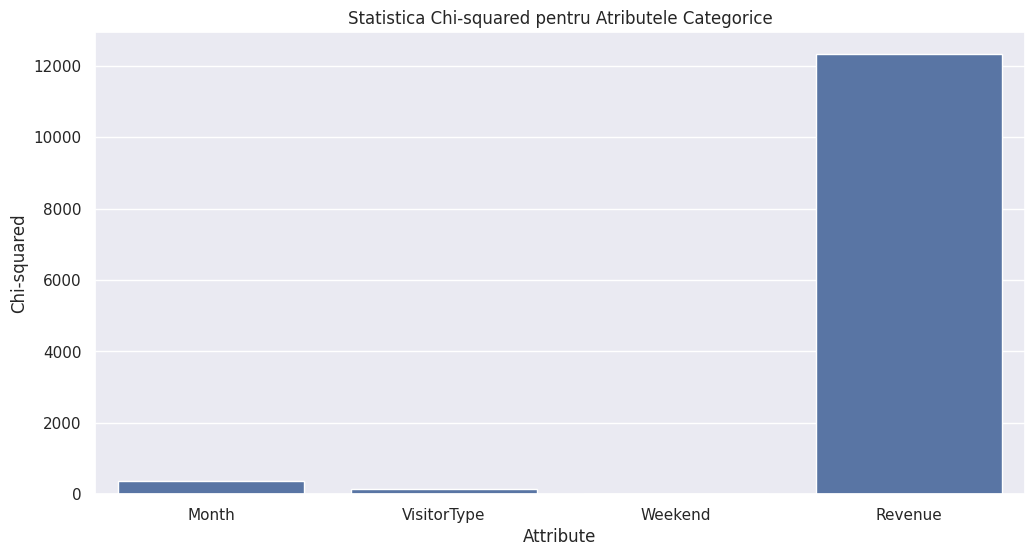

In [1795]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [1796]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [1797]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X_train[column] = label_encoder.fit_transform(X_train[column])
        X_test[column] = label_encoder.transform(X_test[column])  # Utilizăm aceeași transformare pe setul de test
    
    # Normalizarea datelor (Scalare)
    scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
    }

    return X, y

#### Antrenare si Testare

### Functie pentru plotting

In [1798]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [1799]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        variance_metric = np.var(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Variance {metric_name}: {variance_metric}")

#### Datele de fitting ale modelului

In [1800]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

In [1801]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):   
    for scaler_name, scaler in scalers.items():
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)


        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del W, train_acc, test_acc, train_nll, test_nll, W_trace

### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.7424979724249797
Precision folosind MinMaxScaler: 0.17630057803468208
Recall folosind MinMaxScaler: 0.14841849148418493
F1 Score folosind MinMaxScaler: 0.16116248348745046


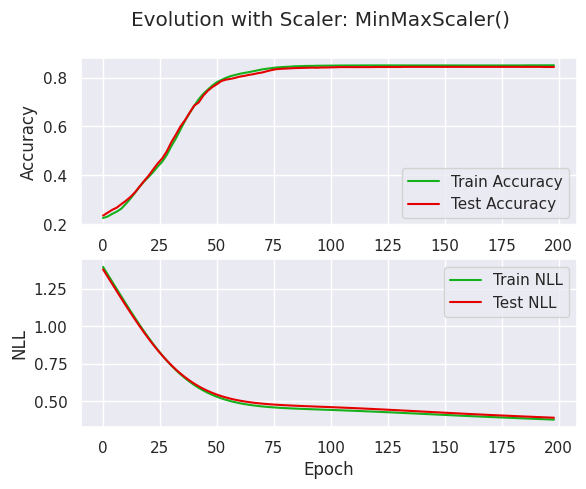

Acuratete folosind StandardScaler: 0.3219789132197891
Precision folosind StandardScaler: 0.07769591426657736
Recall folosind StandardScaler: 0.2822384428223844
F1 Score folosind StandardScaler: 0.12184873949579833


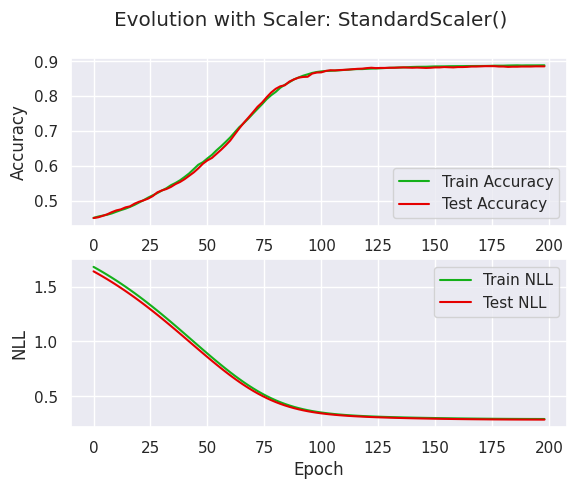

Acuratete folosind RobustScaler: 0.44931062449310627
Precision folosind RobustScaler: 0.025075225677031094
Recall folosind RobustScaler: 0.06082725060827251
F1 Score folosind RobustScaler: 0.03551136363636363


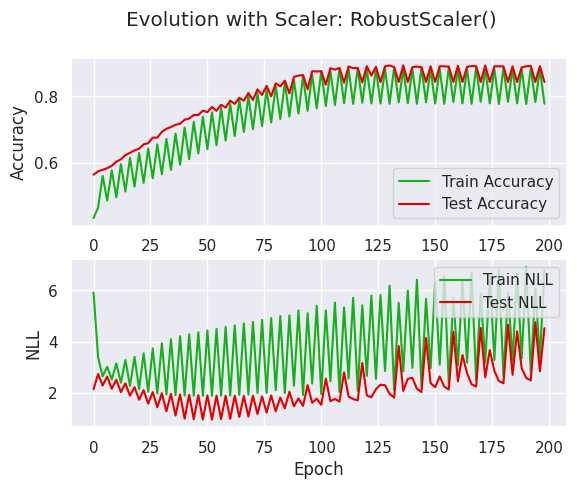


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.6151662611516626
Precision folosind MinMaxScaler: 0.18127962085308058
Recall folosind MinMaxScaler: 0.3722627737226277
F1 Score folosind MinMaxScaler: 0.24382470119521915


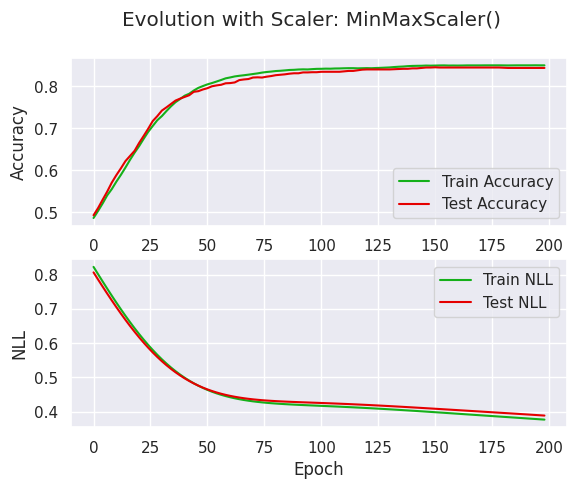

Acuratete folosind StandardScaler: 0.3219789132197891
Precision folosind StandardScaler: 0.07542087542087542
Recall folosind StandardScaler: 0.2725060827250608
F1 Score folosind StandardScaler: 0.11814345991561183


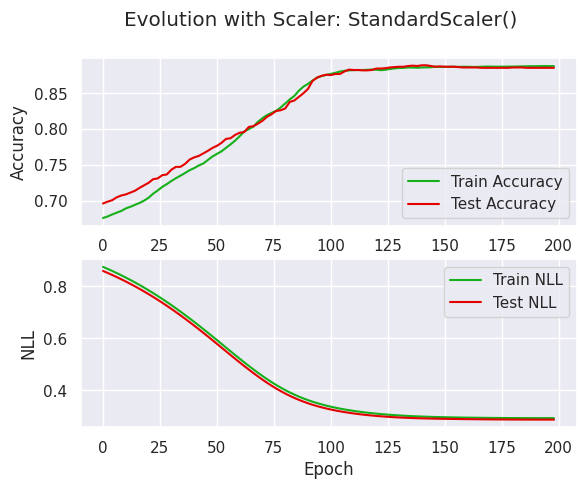

Acuratete folosind RobustScaler: 0.4667477696674777
Precision folosind RobustScaler: 0.04527162977867203
Recall folosind RobustScaler: 0.10948905109489052
F1 Score folosind RobustScaler: 0.06405693950177936


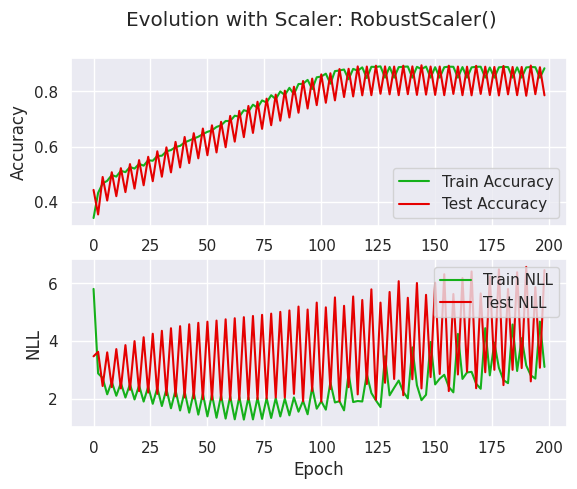


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.5896188158961881
Precision folosind MinMaxScaler: 0.1181702668360864
Recall folosind MinMaxScaler: 0.22627737226277372
F1 Score folosind MinMaxScaler: 0.15525876460767948


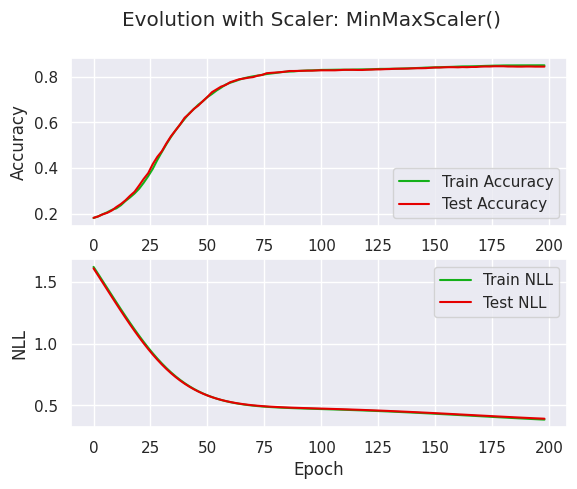

Acuratete folosind StandardScaler: 0.3722627737226277
Precision folosind StandardScaler: 0.09766454352441614
Recall folosind StandardScaler: 0.3357664233576642
F1 Score folosind StandardScaler: 0.1513157894736842


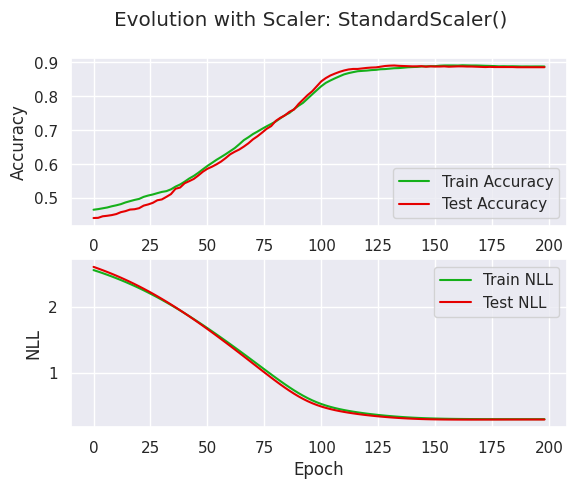

Acuratete folosind RobustScaler: 0.46188158961881587
Precision folosind RobustScaler: 0.03737373737373737
Recall folosind RobustScaler: 0.09002433090024331
F1 Score folosind RobustScaler: 0.05281941470378301


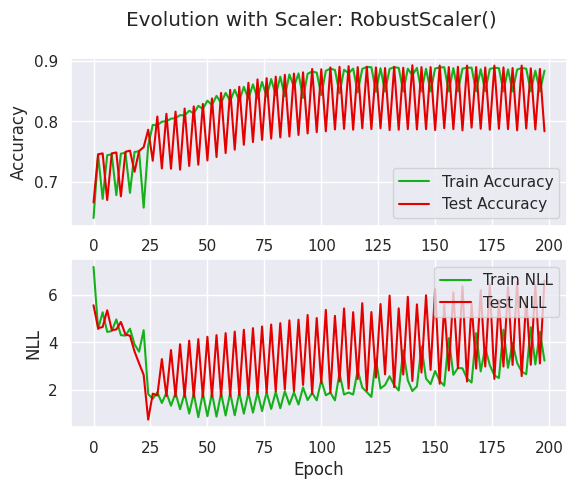


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.5320356853203568
Precision folosind MinMaxScaler: 0.16073059360730593
Recall folosind MinMaxScaler: 0.4282238442822384
F1 Score folosind MinMaxScaler: 0.2337317397078353


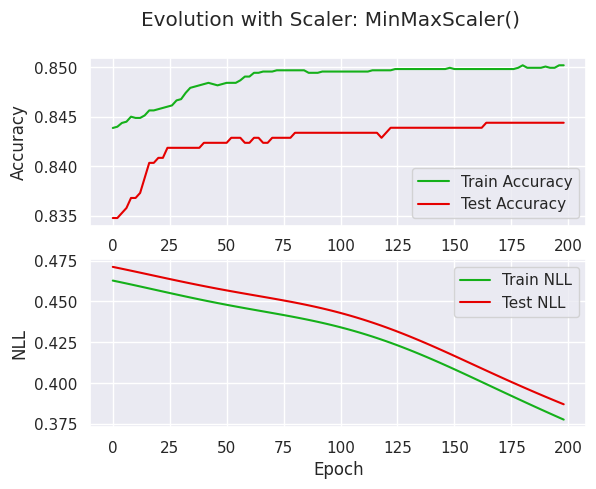

Acuratete folosind StandardScaler: 0.3410381184103812
Precision folosind StandardScaler: 0.08875338753387534
Recall folosind StandardScaler: 0.31873479318734793
F1 Score folosind StandardScaler: 0.13884472708002119


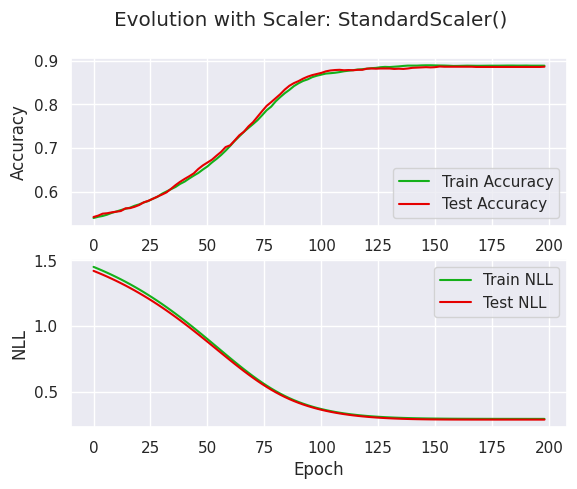

Acuratete folosind RobustScaler: 0.4643146796431468
Precision folosind RobustScaler: 0.04590818363273453
Recall folosind RobustScaler: 0.11192214111922141
F1 Score folosind RobustScaler: 0.0651096956829441


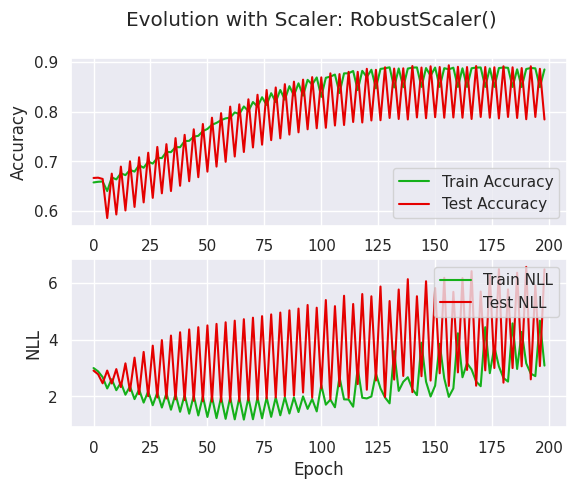


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.8008921330089214
Precision folosind MinMaxScaler: 0.11538461538461539
Recall folosind MinMaxScaler: 0.029197080291970802
F1 Score folosind MinMaxScaler: 0.04660194174757282


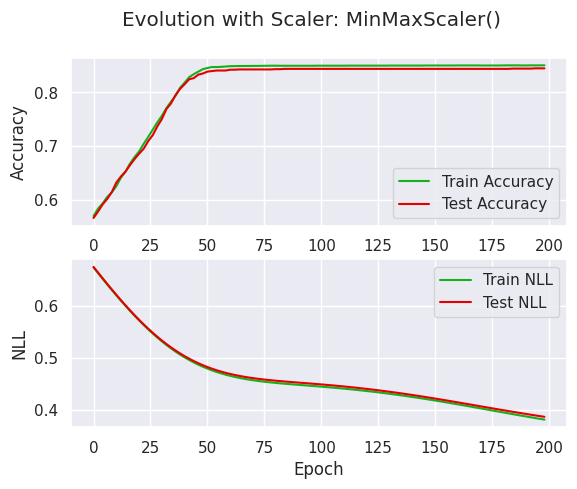

Acuratete folosind StandardScaler: 0.32076236820762366
Precision folosind StandardScaler: 0.07297297297297298
Recall folosind StandardScaler: 0.26277372262773724
F1 Score folosind StandardScaler: 0.11422527763088312


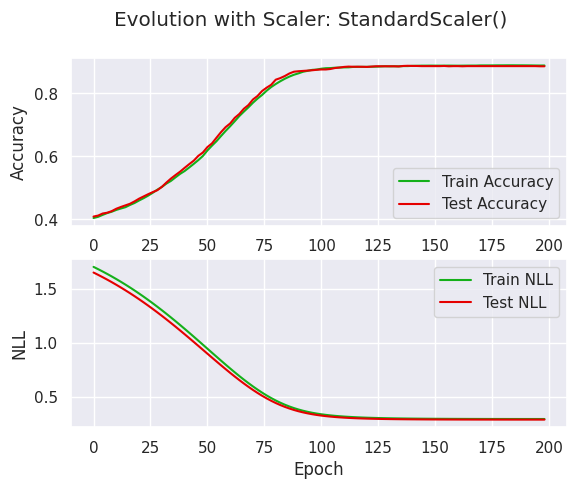

Acuratete folosind RobustScaler: 0.45985401459854014
Precision folosind RobustScaler: 0.02476780185758514
Recall folosind RobustScaler: 0.058394160583941604
F1 Score folosind RobustScaler: 0.03478260869565218


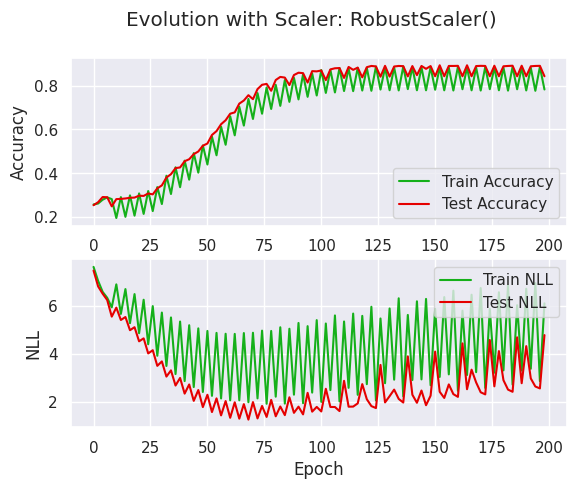


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.6228710462287105
Precision folosind MinMaxScaler: 0.12875536480686695
Recall folosind MinMaxScaler: 0.21897810218978103
F1 Score folosind MinMaxScaler: 0.16216216216216214


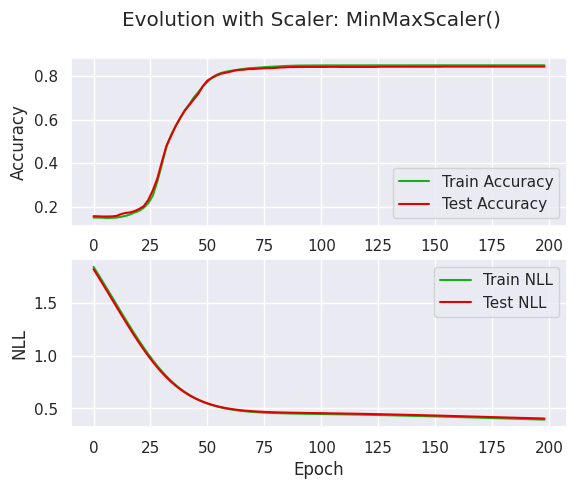

Acuratete folosind StandardScaler: 0.40145985401459855
Precision folosind StandardScaler: 0.11272727272727273
Recall folosind StandardScaler: 0.3771289537712895
F1 Score folosind StandardScaler: 0.17357222844344905


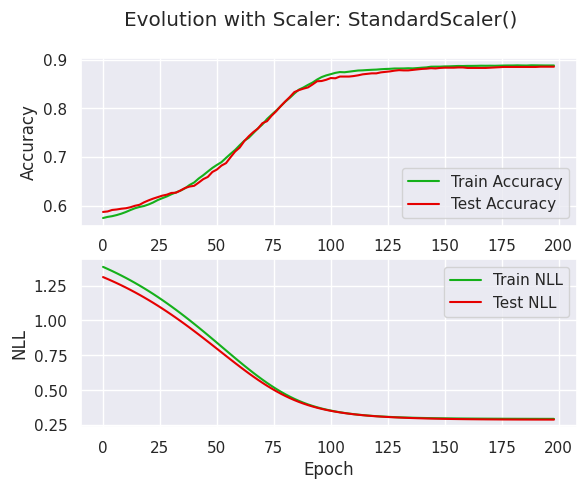

Acuratete folosind RobustScaler: 0.45660989456609896
Precision folosind RobustScaler: 0.03128153380423814
Recall folosind RobustScaler: 0.07542579075425791
F1 Score folosind RobustScaler: 0.044222539229671905


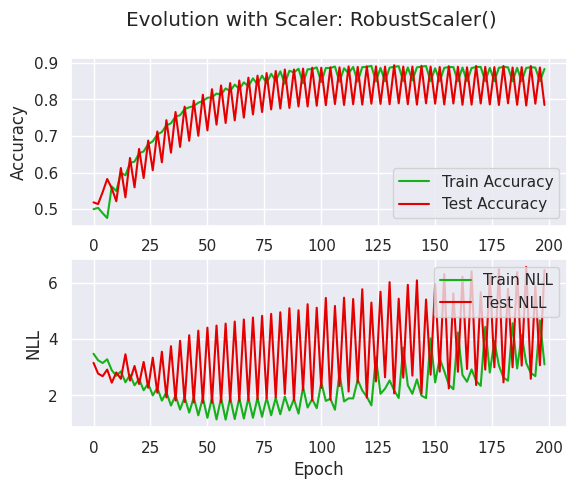


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.42173560421735606
Precision folosind MinMaxScaler: 0.1325126719768284
Recall folosind MinMaxScaler: 0.44525547445255476
F1 Score folosind MinMaxScaler: 0.20424107142857145


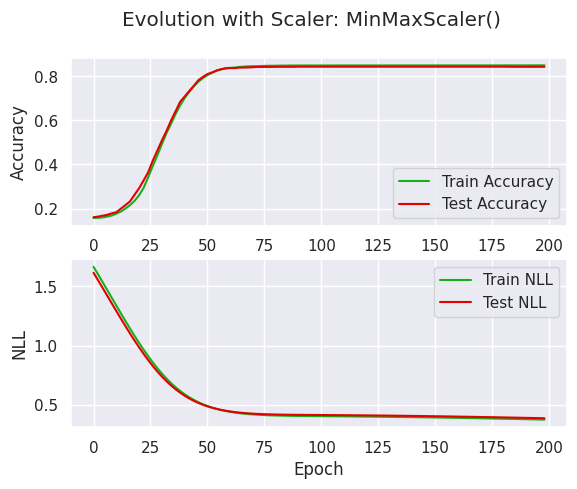

Acuratete folosind StandardScaler: 0.32076236820762366
Precision folosind StandardScaler: 0.06293222683264177
Recall folosind StandardScaler: 0.22141119221411193
F1 Score folosind StandardScaler: 0.09800753904146473


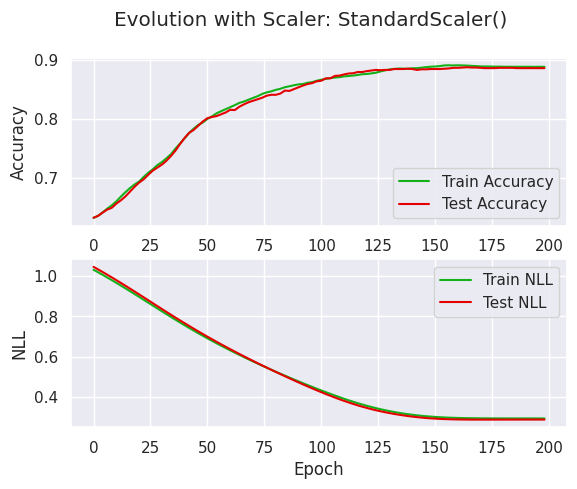

Acuratete folosind RobustScaler: 0.4537712895377129
Precision folosind RobustScaler: 0.02631578947368421
Recall folosind RobustScaler: 0.06326034063260341
F1 Score folosind RobustScaler: 0.03716940671908506


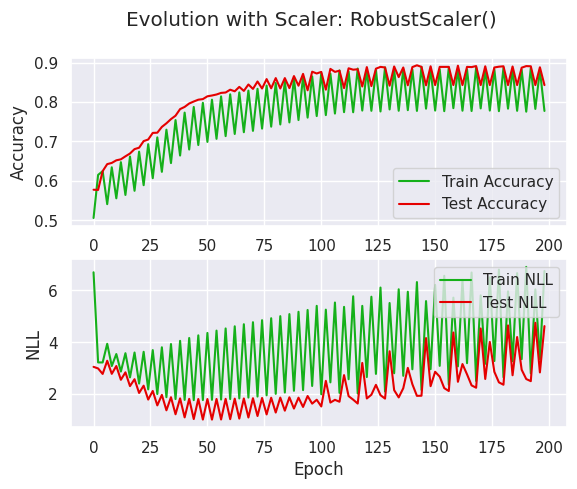


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.7562854825628548
Precision folosind MinMaxScaler: 0.14285714285714285
Recall folosind MinMaxScaler: 0.09245742092457421
F1 Score folosind MinMaxScaler: 0.11225997045790251


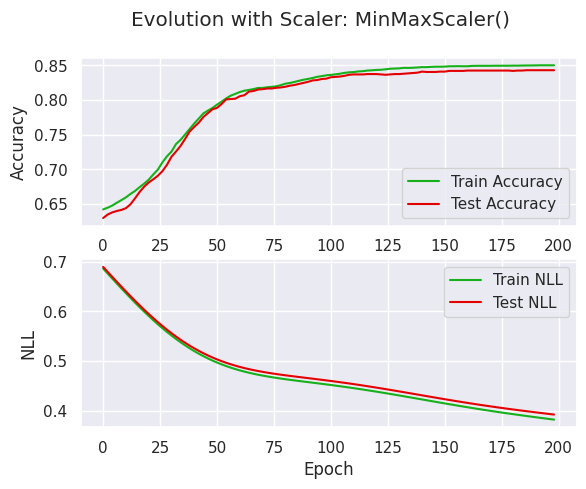

Acuratete folosind StandardScaler: 0.42416869424168696
Precision folosind StandardScaler: 0.1293166789125643
Recall folosind StandardScaler: 0.4282238442822384
F1 Score folosind StandardScaler: 0.1986455981941309


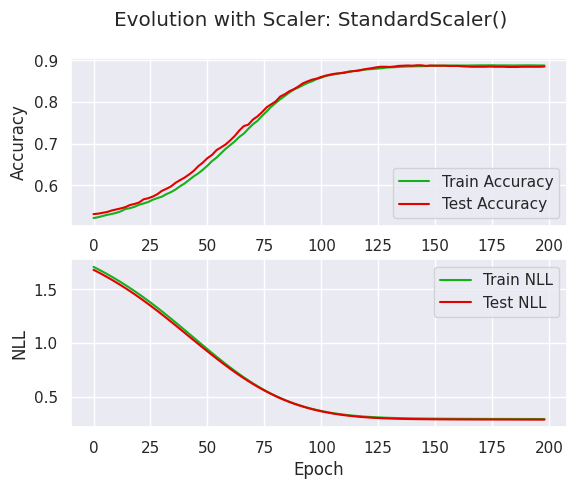

Acuratete folosind RobustScaler: 0.4545823195458232
Precision folosind RobustScaler: 0.0439453125
Recall folosind RobustScaler: 0.10948905109489052
F1 Score folosind RobustScaler: 0.0627177700348432


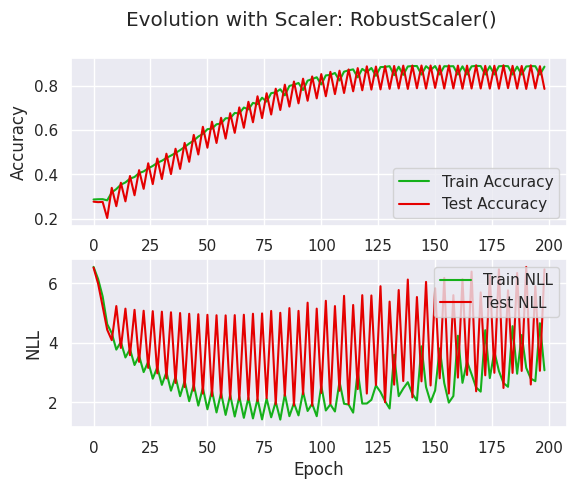


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.7408759124087592
Precision folosind MinMaxScaler: 0.11224489795918367
Recall folosind MinMaxScaler: 0.08029197080291971
F1 Score folosind MinMaxScaler: 0.09361702127659574


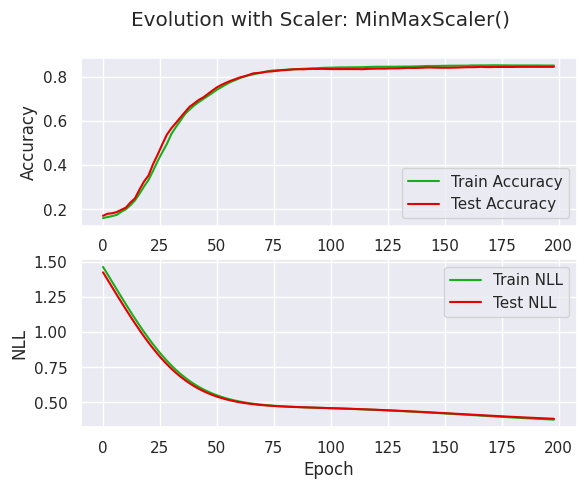

Acuratete folosind StandardScaler: 0.32116788321167883
Precision folosind StandardScaler: 0.06597938144329897
Recall folosind StandardScaler: 0.23357664233576642
F1 Score folosind StandardScaler: 0.10289389067524116


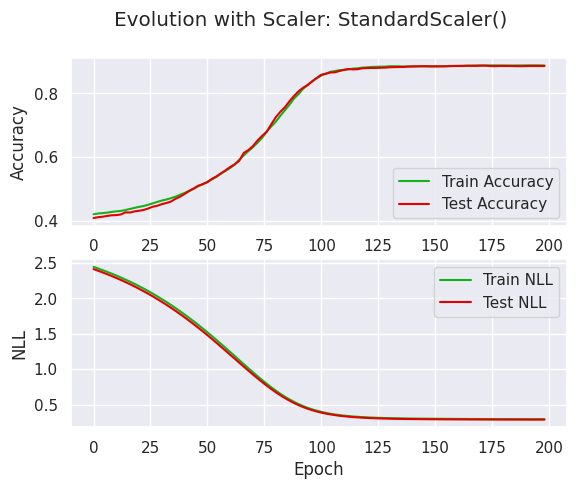

Acuratete folosind RobustScaler: 0.6524736415247364
Precision folosind RobustScaler: 0.1558641975308642
Recall folosind RobustScaler: 0.24574209245742093
F1 Score folosind RobustScaler: 0.1907459867799811


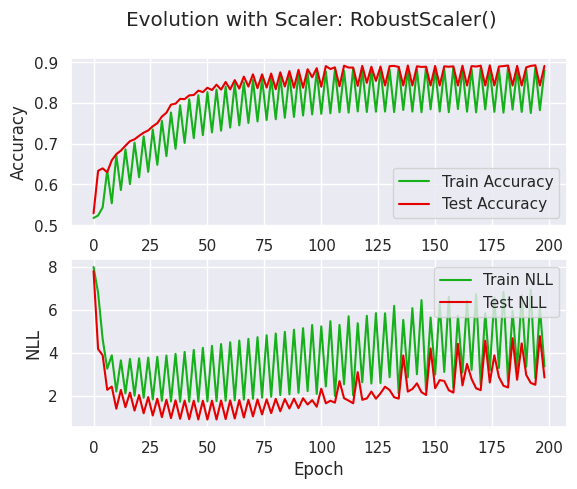


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.8102189781021898
Precision folosind MinMaxScaler: 0.09859154929577464
Recall folosind MinMaxScaler: 0.0170316301703163
F1 Score folosind MinMaxScaler: 0.029045643153526972


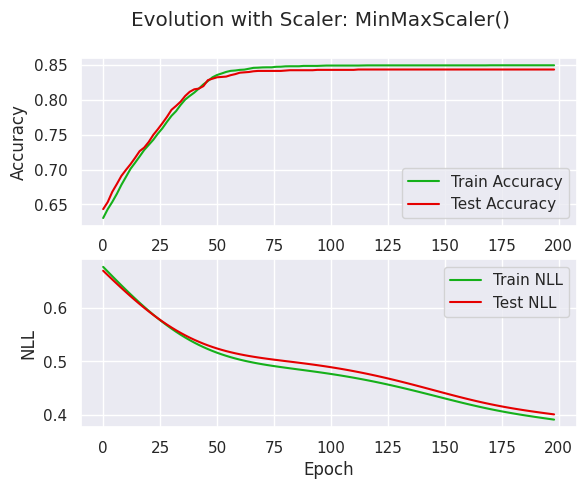

Acuratete folosind StandardScaler: 0.32319545823195456
Precision folosind StandardScaler: 0.0703551912568306
Recall folosind StandardScaler: 0.25060827250608275
F1 Score folosind StandardScaler: 0.10986666666666667


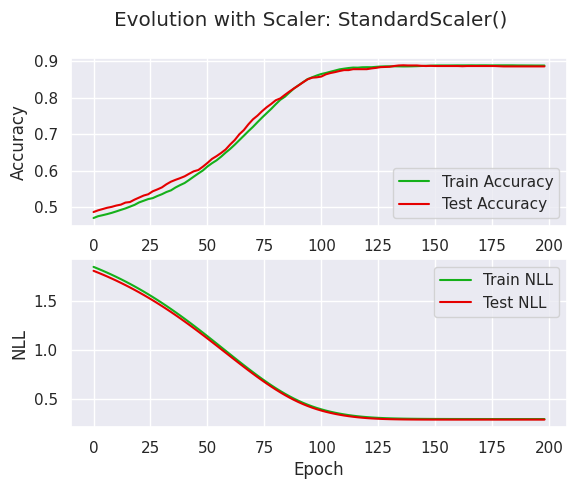

Acuratete folosind RobustScaler: 0.6581508515815085
Precision folosind RobustScaler: 0.02
Recall folosind RobustScaler: 0.021897810218978103
F1 Score folosind RobustScaler: 0.020905923344947733


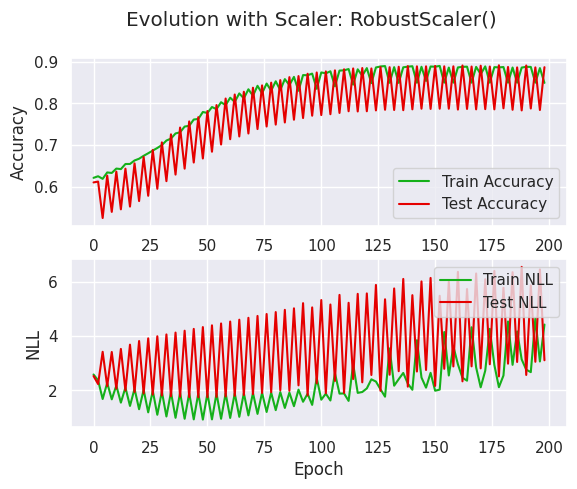


FINAL STATISTICS

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.6632197891321979
Variance Accuracy: 0.014641730947208064

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.34687753446877534
Variance Accuracy: 0.0013457375538466708

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.4977696674776967
Variance Accuracy: 0.006230599905675829

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.1366827301611567
Variance Precision: 0.0007099578838551117

Metrics for Precision with StandardScaler after 10 runs:
Mean Precision: 0.08538184448913255
Variance Precision: 0.00042587898524362765

Metrics for Precision with RobustScaler after 10 runs:
Mean Precision: 0.04558034116285468
Variance Precision: 0.0014316307674375381

Metrics for Recall with MinMaxScaler after 10 runs:
Mean Recall: 0.20583941605839415
Variance Recall: 0.023382764724338596

Metrics for Recall with StandardScaler after 10 runs:
Mean Rec

In [1802]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

# Print information about the training dataset
(N, D) = X.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D}") 

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)

print("\nFINAL STATISTICS")
# Print accuracy metrics
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print_metrics("F1 Score", f1_score_results, num_iterations)

### 2. Implementare folosind scikit-learn

In [1803]:
results = []

for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    
    # Antrenarea modelului
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Evaluarea modelului
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Scaler': scaler_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Afisarea rezultatelor
results_df = pd.DataFrame(results)
print(results_df)

ValueError: could not convert string to float: 'Nov'

## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

### 2. Implementare manuală